# CS310 Natural Language Processing
# Lab 2: Neural Text Classification

In this lab, we will practice building a neural network for text classification. 

The tutorial code is adopted from the official PyTorch tutorial: *Text classification with the torchtext library*

https://pytorch.org/tutorials/beginner/text_sentiment_ngrams_tutorial.html#text-classification-with-the-torchtext-library

## Install torchtext

Url: https://pypi.org/project/torchtext/
```bash
conda install -c pytorch torchtext
```

You may or may not need to manually install the following packages:
    
```bash
pip install chardet
pip install -U portalocker>=2.0.0
```

or with conda

```bash
conda install -c conda-forge 'portalocker>=2.0.0'
```

## Load data

In [2]:
import torch
from torchtext.datasets import SST2 # SST2 is the sentiment analysis dataset, binary

In [3]:
# Check the raw data
train_iter = iter(SST2(split='train'))
# 封装成迭代器
count = 0
for item in train_iter:
    print(item)
    count += 1
    if count > 5:
        break

('hide new secretions from the parental units', 0)
('contains no wit , only labored gags', 0)
('that loves its characters and communicates something rather beautiful about human nature', 1)
('remains utterly satisfied to remain the same throughout', 0)
('on the worst revenge-of-the-nerds clichés the filmmakers could dredge up', 0)
("that 's far too tragic to merit such superficial treatment", 0)


## Apply Tokenizer

In [4]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

tokenizer = get_tokenizer("basic_english")
# 创建分词器，这里使用的是basic_english，即只保留英文单词，去掉标点符号等；将文本字符串拆分成单词或标记（tokens）。
def yield_tokens(data_iter):
    for text, _ in data_iter: # 这里只取文本部分，不取标签
        yield tokenizer(text) # 返回的是一个迭代器，每次迭代返回一个单词

In [5]:
# Check the output of yield_tokens()
count = 0
for tokens in yield_tokens(iter(SST2(split='train'))): # Use a new iterator
    print(tokens)
    count += 1
    if count > 3:
        break

['hide', 'new', 'secretions', 'from', 'the', 'parental', 'units']
['contains', 'no', 'wit', ',', 'only', 'labored', 'gags']
['that', 'loves', 'its', 'characters', 'and', 'communicates', 'something', 'rather', 'beautiful', 'about', 'human', 'nature']
['remains', 'utterly', 'satisfied', 'to', 'remain', 'the', 'same', 'throughout']


## Build Vocabulary

First, we build the vocabulary using the `build_vocab_from_iterator` function.

In [6]:
vocab = build_vocab_from_iterator(yield_tokens(iter(SST2(split='train'))), specials=["<unk>"]) 
# 从迭代器中构建词汇表，这里使用的是SST2数据集的训练集，特殊标记是"<unk>"，即未知词
vocab.set_default_index(vocab["<unk>"])# 设置默认索引，即未知词的索引；当查询词汇表中不存在的词时，返回该索引

You can see that all strings are converted into integer IDs.

In [7]:
# Check the vocab
# 每个单词在词汇表中的索引
print(vocab(['here', 'is', 'an', 'example']))
print(vocab(['hide', 'new', 'secretions', 'from', 'the', 'parental', 'units']))
print(vocab(['of', 'saucy']))

# What about unknown words, i.e., out-of-vocabulary (OOV) words?
print(vocab(['here', 'is', 'a', '@#$@!#$%']))

[224, 10, 16, 1567]
[4579, 92, 13266, 38, 1, 7742, 10000]
[5, 7100]
[224, 10, 3, 0]


Next, further define the `text_pipeline` and `label_pipeline` functions, for converting strings to integers. 

In [8]:
text_pipeline = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: int(x)

# Test text_pipeline()
tokens = text_pipeline('here is the an example')
print(tokens)

# Test label_pipeline()
lbl = label_pipeline('1')
print(lbl)

[224, 10, 1, 16, 1567]
1


## T1. Batchify Data 

Your goal is to define the `Collate_batch` function, which will be used to process the "raw" data batch.

*Hint*: In the loop of `collate_batch`, the labels, tokens, and the offsets of all the examples are collected into three lists. Finally, the lists are converted into tensors. 

*Hint*: The `offsets` need to contain the cumulative positions of tokens in the batch. 
For example, if the batch contains 3 examples, whose lengths are `[1,3,2]`, then the final offsets should be `[0,1,4,6]`.
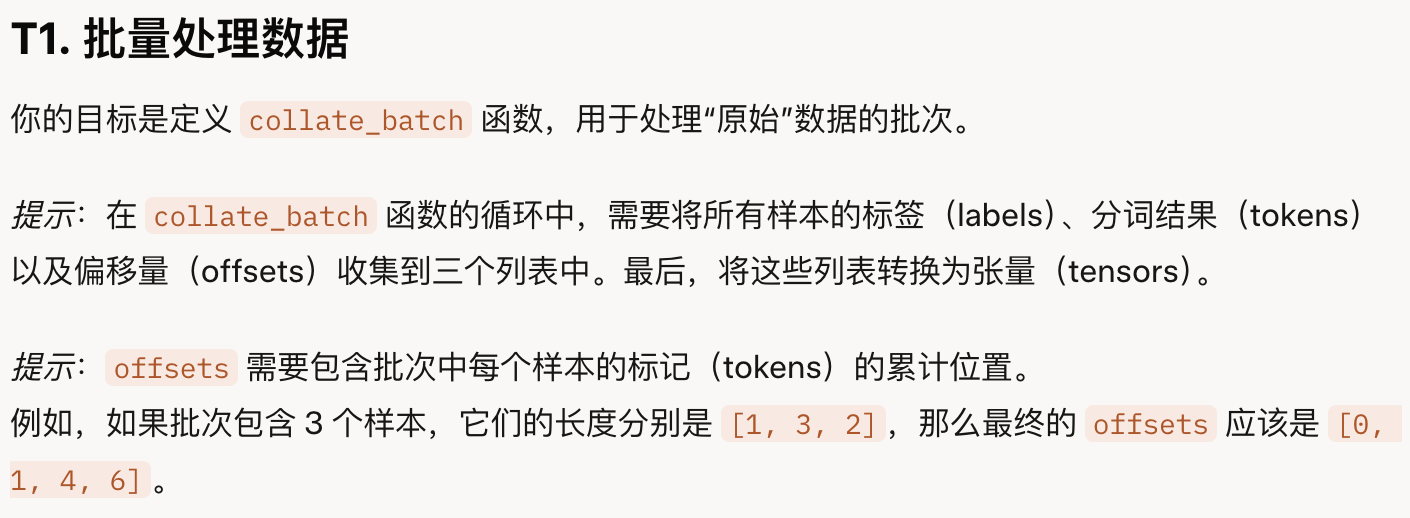

In [9]:
from torch.utils.data import DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def collate_batch(batch):
    label_list, token_ids_list, offsets = [], [], [0]
    for _text, _label in batch:
        label_list.append(label_pipeline(_label))
        processed_text = text_pipeline(_text)
        if len(processed_text) == 0:  # 处理空文本
            processed_text = [vocab["<unk>"]]  # 用 <unk> 填充
        token_ids = torch.tensor(processed_text, dtype=torch.int64)
        token_ids_list.append(token_ids)
        offsets.append(offsets[-1] + token_ids.size(0))  # 累计偏移量

# offset表示每个样本的标记（tokens）在拼接后的扁平列表中的起始位置；累积的，用于区分批次中不同样本的边界
    ### START YOUR CODE ###
    labels = torch.tensor(label_list, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1], dtype=torch.int64)  # 去掉最后一个累计值，只保留起始位置
    token_ids = torch.cat(token_ids_list, dim=0)  # 将所有 token_ids 拼接成一个扁平张量；将这些张量沿第 0 维拼接成一个扁平张量
    ### END YOUR CODE ###

    return labels.to(device), token_ids.to(device), offsets.to(device)

Next, use the defined `collate_batch` function to create the dataloader.

In [10]:
# Use collate_batch to generate the dataloader
train_iter = SST2(split="train")
dataloader = DataLoader(
    train_iter, batch_size=8, shuffle=False, collate_fn=collate_batch
)

In [11]:
# Test the dataloader
for i, (labels, token_ids, offsets) in enumerate(dataloader):
    if i == 0:
        break

# What does offsets mean?
print('Number of tokens in this batch: ', token_ids.size(0))
print('Number of examples in one batch: ', labels.size(0))
print('Example 0: ', token_ids[offsets[0]:offsets[1]])
print('Example 7: ', token_ids[offsets[7]:])

# You are expected to see the following output:
# Number of tokens in this batch:  82
# Number of examples in one batch:  8
# Example 0:  tensor([ 4579,    92, 13266,    38,     1,  7742, 10000])
# Example 7:  tensor([   5, 7100])

Number of tokens in this batch:  82
Number of examples in one batch:  8
Example 0:  tensor([ 4579,    92, 13266,    38,     1,  7742, 10000])
Example 7:  tensor([   5, 7100])


## T2. Define the Model

The model consists of two parts of parameters: an embedding layer and a fully connected layer.

Your need to first initialize an `nn.EmbeddingBag` instance and a `nn.Linear` instance:
- The embedding layer should be initialized with `vocab_size`, `embed_dim`, and `sparse=False`.
- The fully connected layer should have `embed_dim` as input size and `num_class` as output size.

Then, in the `forward` function, the embedding layer should called with `token_ids` and `offsets` as inputs. The output of embedding layer is fed to the fully connected layer to get the final output. 
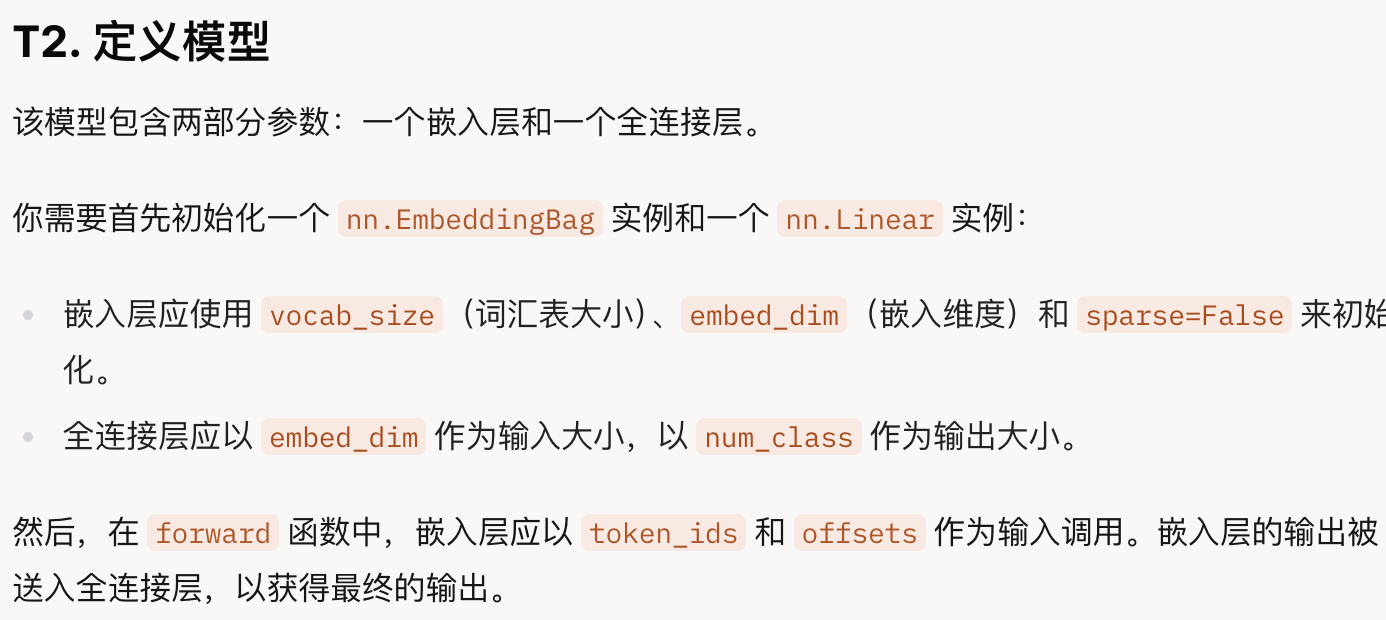

In [12]:
from torch import nn

class TextClassificationModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class):
        super(TextClassificationModel, self).__init__()
        ### START YOUR CODE ###
        # 初始化嵌入层
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=False)
        # 初始化全连接层
        self.fc = nn.Linear(embed_dim, num_class)
        ### END YOUR CODE ###
        self.init_weights()

    def init_weights(self):
        initrange = 0.5 # 初始化权重的范围
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, token_ids, offsets):
        ### START YOUR CODE ###
        embedded = self.embedding(token_ids, offsets)  # 嵌入层
        out = self.fc(embedded) # 全连接层
        ### END YOUR CODE ###
        return out

In [13]:
# Build the model
train_iter = iter(SST2(split='train'))
num_class = len(set([label for (_, label) in train_iter]))
vocab_size = len(vocab)
emsize = 64 # embedding size
model = TextClassificationModel(vocab_size, emsize, num_class).to(device)

In [14]:
# Test the model
model.eval()
with torch.no_grad():
    for i, (labels, token_ids, offsets) in enumerate(dataloader):
        output = model(token_ids, offsets)
        # print(f"batch {i} output: {output}")
        if i == 0:
            break

print('output size:', output.size())

# You are expected to see the following output:
# output size: torch.Size([8, 2])

output size: torch.Size([8, 2])


/opt/anaconda3/envs/NLP/lib/python3.11/site-packages/torch/utils/data/datapipes/iter/combining.py:297: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  warnings.warn("Some child DataPipes are not exhausted when __iter__ is called. We are resetting "


## T3. Define the loss function

Cross entropy loss should be used. You can use `torch.nn.CrossEntropyLoss` to define the loss function.

In [15]:
from torch.utils.data.dataset import random_split
from torchtext.data.functional import to_map_style_dataset

# Hyperparameters
EPOCHS = 10  # epoch
LR = 5  # learning rate
BATCH_SIZE = 8  # batch size for training

### START YOUR CODE ###
criterion = torch.nn.CrossEntropyLoss()  # 损失函数
### END YOUR CODE ###

optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)

Test if the loss function `criterion` works

In the cell below, implement the **manual computation** of cross entropy loss. Use the formula $-y_i\log(\hat{y_i})$, 

where $y_i$ is the $i$-th ground truth label in `labels`, and $\hat{y_i}$ is the predicted probability in `output` of the correponding label.

In [16]:
# First, obtain some output and labels
model.eval()
with torch.no_grad():
    for i, (labels, token_ids, offsets) in enumerate(dataloader):
        output = model(token_ids, offsets)
        # print(f"batch {i} output: {output}")
        if i == 0:
            break
print('output shape:', output.shape)

loss = criterion(output, labels)
print('loss:', loss)

# Manually calculate the loss
loss_manual = []
for i in range(output.shape[0]):
    ### START YOUR CODE ###
    probs = torch.softmax(output[i], dim=0)
    y_i=labels[i]
    y_hat_i=probs[y_i]
    l = -torch.log(y_hat_i)
    ### END YOUR CODE ###
    loss_manual.append(l)
loss_manual = torch.stack(loss_manual)
print('loss_manual mean:', loss_manual.mean())

# You are expected to see the following output:
# output shape: torch.Size([8, 2])
# loss: tensor(XXXXX)
# loss_manual mean: tensor(XXXXX)
# loss equals loss_manual: tensor(True)

output shape: torch.Size([8, 2])
loss: tensor(0.8091)
loss_manual mean: tensor(0.8091)


## T4. Train and Evaluate Functions

Define train and evaluate functions.

You need to implement the forward pass, loss computation, backward propagation, and parameter update in the `train` function. 

Also, for each batch of data, calculate the total number of correctly predicted examples, by comparing `output` and `labels`.

In [17]:
import time

def train(model, dataloader, optimizer, criterion, epoch: int):
    model.train()
    total_acc, total_count = 0, 0
    log_interval = 500
    start_time = time.time()

    for idx, (labels, token_ids, offsets) in enumerate(dataloader):
        optimizer.zero_grad()
        ### START YOUR CODE ###
        # Forward pass
        output = model(token_ids, offsets) # 获取模型输出
        ### END YOUR CODE ###
        try:
            ### START YOUR CODE ###
            # Compute loss
            loss = criterion(output, labels) # 计算损失
            ### END YOUR CODE ###
        except Exception:
            print('Error in loss calculation')
            print('output: ', output.size())
            print('labels: ', labels.size())
            print('token_ids: ', token_ids)
            print('offsets: ', offsets)
            raise
        ### START YOUR CODE ###
        # Backward propagation, grad clipping, and optimization
        loss.backward() # call loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1) # Clip gradients to avoid exploding gradients
        optimizer.step() # call optimizer.step()
        ### END YOUR CODE ###

        ### START YOUR CODE ###
        # Calculate correct prediction in current batch
        pred = output.argmax(dim=1,keepdim=False) # Get the class with the highest probability
        correct= pred.eq(labels).sum().item() # Calculate the number of correct predictions
        total_acc += correct
        ### END YOUR CODE ###

        total_count += labels.size(0)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print(
                "| epoch {:3d} | {:5d}/{:5d} batches "
                "| accuracy {:8.3f}".format(
                    epoch, idx, len(dataloader), total_acc / total_count
                )
            )
            total_acc, total_count = 0, 0
            start_time = time.time()

@torch.no_grad()
def evaluate(model, dataloader, criterion):
    model.eval()
    total_acc, total_count = 0, 0

    for idx, (label, text, offsets) in enumerate(dataloader):
        ### START YOUR CODE ###
        # Similar to the code in train function, but without backpropagation
        output = model(text, offsets) # Forward pass without updating gradients
        loss = criterion(output, label)
        total_acc += (output.argmax(1) == label).sum().item()
        ### END YOUR CODE ###
        total_count += label.size(0)

    return total_acc / total_count

## Load train, valid, and test data

In [18]:
# Prepare train, valid, and test data
train_iter = SST2(split="train")
test_iter = SST2(split="test")
train_dataset = to_map_style_dataset(train_iter)
test_dataset = to_map_style_dataset(test_iter)

num_train = int(len(train_dataset) * 0.95)
split_train_, split_valid_ = random_split(
    train_dataset, [num_train, len(train_dataset) - num_train]
)

train_dataloader = DataLoader(
    split_train_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)
valid_dataloader = DataLoader(
    split_valid_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)
test_dataloader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)

## Main Training Loop

In [19]:
# Run the training loop
total_accu = None
for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()

    train(model, train_dataloader, optimizer, criterion, epoch)
    accu_val = evaluate(model, valid_dataloader, criterion)

    if total_accu is not None and total_accu > accu_val:
        scheduler.step()
    else:
        total_accu = accu_val

    print("-" * 59)
    print(
        "| end of epoch {:3d} | time: {:5.2f}s | "
        "valid accuracy {:8.3f} ".format(
            epoch, time.time() - epoch_start_time, accu_val
        )
    )
    print("-" * 59)

| epoch   1 |   500/ 7998 batches | accuracy    0.594
| epoch   1 |  1000/ 7998 batches | accuracy    0.673
| epoch   1 |  1500/ 7998 batches | accuracy    0.739
| epoch   1 |  2000/ 7998 batches | accuracy    0.750
| epoch   1 |  2500/ 7998 batches | accuracy    0.777
| epoch   1 |  3000/ 7998 batches | accuracy    0.792
| epoch   1 |  3500/ 7998 batches | accuracy    0.792
| epoch   1 |  4000/ 7998 batches | accuracy    0.804
| epoch   1 |  4500/ 7998 batches | accuracy    0.804
| epoch   1 |  5000/ 7998 batches | accuracy    0.818
| epoch   1 |  5500/ 7998 batches | accuracy    0.832
| epoch   1 |  6000/ 7998 batches | accuracy    0.833
| epoch   1 |  6500/ 7998 batches | accuracy    0.841
| epoch   1 |  7000/ 7998 batches | accuracy    0.832
| epoch   1 |  7500/ 7998 batches | accuracy    0.840
-----------------------------------------------------------
| end of epoch   1 | time:  5.78s | valid accuracy    0.843 
-----------------------------------------------------------
| epoch  

In [20]:
# Save the model
torch.save(model.state_dict(), "text_classification_model.pth")

## Evaluate with Test Data

This is a necessary step. But since the `test` split of SST2 is not annotated, we will use the `dev` split here to pretend it is the test data.

In [21]:
accu_test = evaluate(model, valid_dataloader, criterion)
print("test accuracy {:8.3f}".format(accu_test))

# Your test accuracy should be around 0.9

test accuracy    0.901


## Predict

Test the model with a few unannotated examples.

In [22]:
sentiment_labels = ['negative', 'positive']

def predict(text, model, vocab, tokenizer, labels):
    model.eval()
    with torch.no_grad():
        text = torch.tensor(vocab(tokenizer(text)), device=device)
        output = model(text, torch.tensor([0], device=device))
        return labels[output.argmax(1).item()]

ex_text_str = "A very well-made, funny and entertaining picture."
print("This is a %s sentiment." % (predict(ex_text_str, model, vocab, tokenizer, sentiment_labels)))

This is a positive sentiment.


Congratulations! You have successfully built and trained a neural network model to classify sentiment in text data.